<a href="https://colab.research.google.com/github/gabriel-cm-saldanha/previsao_demanda_prophet/blob/main/Previs%C3%A3o_de_Demanda_com_Prophet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img alt="Colaboratory logo" width="15%" src="https://raw.githubusercontent.com/carlosfab/escola-data-science/master/img/novo_logo_bg_claro.png">

#### **Data Science na Prática 4.0**


---

### PREVISÃO DE DEMANDA

Como falamos antes, nossos templates ficarão cada vez mais simples!!

O objetivo desse projeto é prever a demanda por vinhos em lojas especializadas em vinho. Para esse projeto, temos 2 datasets, um sobre o catálogo de vinhos da loja e outro sobre as vendas.

* [Dados sobre os produtos](https://raw.githubusercontent.com/rafaelnduarte/sigmoidal_data/master/products.csv)
* [Dados de Vendas](https://raw.githubusercontent.com/rafaelnduarte/sigmoidal_data/master/sales-clean.csv)

Nesse projeto, é VITAL que haja MUITA ATENÇÃO sobre os detalhes mencionados que permeiam as análise de séries temporais. É um projeto que demanda muita atenção e cuidado, e uma documentação feita minuciosamente.

Aqui, queremos, como sempre, trazer o máximo de autonomia e independência pra vocês. Façam o download, e disponibilizem os seus dados, carreguem eles aqui, e desenvolvam o projeto.

## Objetivos

* Contextualização do problema, dos dados, do projeto.
* Análise completa dos dados e do problema (Na mão, ou com Pandas Profiling, SweetViz, etc)
* Desenvolver uma solução de Machine Learning eficiente com PyCaret para Classificação

LEMBREM-SE: Documentação, Storytelling, Artigo com Código!

Mãos à obra e boa sorte!


## Sobre os Produtos

### Dicionário de Variáveis

* item_id = Número de identificação do item
* name = Nome do vinho
* producer = Nome do Produtor do vinho
* country = País de origem do vinho
* vintage = Safra
* kind = Tipo do vinho
      Sparkling = Espumante
      Rose Sparkling = Espumante Rose
      White = Branco
      Rosé = Rosé
      Red = Tinto
* price_brl = Preço em reais
* price_usd = Preço em dólar americano

## Importando as Bibliotecas e Preparando o ambiente

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# statsmodel
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA

# Importando o Prophet
from prophet import Prophet
import logging

logging.getLogger().setLevel(logging.ERROR)
%matplotlib inline
sns.set_style()

## Analise dos dados dos produtos

In [ ]:
df_products = pd.read_csv('https://raw.githubusercontent.com/rafaelnduarte/sigmoidal_data/master/products.csv')
print(df_products.shape)
df_products.head()

(219, 9)


,item_id,name,producer,country,region,vintage,kind,price_brl,price_usd
0,1,Philipponnat Royale Reserve Brut,Philipponat,France,Champagne,NV,sparkling,339.60,58.75
1,2,Philipponnat Royale Reserve Rosé,Philipponat,France,Champagne,NV,rose sparkling,489.00,84.60
2,3,Philipponnat Cuvée 1522 Grand Cru Extra Brut,Philipponat,France,Champagne,2009,sparkling,789.00,136.51
3,4,Philipponnat Cuvée 1522 1er Cru Rosé,Philipponat,France,Champagne,2008,rose sparkling,899.40,155.61
4,5,Philipponnat Clos Des Goisses Brut,Philipponat,France,Champagne,2009,sparkling,"1,548.00",267.82


Ao visualizarmos as 5 primeiras entradas já nos deparamos com um futuro problema, a presença de virgulas em colunas númericas como `price_brl` e `price_usd`, que como podemos observar abaixo, estão sendo classificadas como tipo `object`.
Para resolvermos esse problema, iremos remover as vírgulas dessas colunas e transforma-las no tipo float.


In [ ]:
df_products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 219 entries, 0 to 218
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   item_id    219 non-null    int64 
 1   name       219 non-null    object
 2   producer   219 non-null    object
 3   country    219 non-null    object
 4   region     219 non-null    object
 5   vintage    219 non-null    object
 6   kind       219 non-null    object
 7   price_brl  219 non-null    object
 8   price_usd  219 non-null    object
dtypes: int64(1), object(8)
memory usage: 15.5+ KB


In [ ]:
df_products.replace(',',"", regex=True, inplace=True)
df_products['price_usd'] = df_products['price_usd'].astype(float)
df_products['price_brl'] = df_products['price_brl'].astype(float)
df_products.head()

,item_id,name,producer,country,region,vintage,kind,price_brl,price_usd
0,1,Philipponnat Royale Reserve Brut,Philipponat,France,Champagne,NV,sparkling,339.6,58.75
1,2,Philipponnat Royale Reserve Rosé,Philipponat,France,Champagne,NV,rose sparkling,489.0,84.60
2,3,Philipponnat Cuvée 1522 Grand Cru Extra Brut,Philipponat,France,Champagne,2009,sparkling,789.0,136.51
3,4,Philipponnat Cuvée 1522 1er Cru Rosé,Philipponat,France,Champagne,2008,rose sparkling,899.4,155.61
4,5,Philipponnat Clos Des Goisses Brut,Philipponat,France,Champagne,2009,sparkling,1548.0,267.82


In [ ]:
df_products['vintage'] = df_products['vintage'].replace('NV','0')
df_products['vintage'] = pd.to_numeric(df_products['vintage'])
df_products.head()

,item_id,name,producer,country,region,vintage,kind,price_brl,price_usd
0,1,Philipponnat Royale Reserve Brut,Philipponat,France,Champagne,0,sparkling,339.6,58.75
1,2,Philipponnat Royale Reserve Rosé,Philipponat,France,Champagne,0,rose sparkling,489.0,84.60
2,3,Philipponnat Cuvée 1522 Grand Cru Extra Brut,Philipponat,France,Champagne,2009,sparkling,789.0,136.51
3,4,Philipponnat Cuvée 1522 1er Cru Rosé,Philipponat,France,Champagne,2008,rose sparkling,899.4,155.61
4,5,Philipponnat Clos Des Goisses Brut,Philipponat,France,Champagne,2009,sparkling,1548.0,267.82


In [ ]:
df_products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 219 entries, 0 to 218
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   item_id    219 non-null    int64  
 1   name       219 non-null    object 
 2   producer   219 non-null    object 
 3   country    219 non-null    object 
 4   region     219 non-null    object 
 5   vintage    219 non-null    int64  
 6   kind       219 non-null    object 
 7   price_brl  219 non-null    float64
 8   price_usd  219 non-null    float64
dtypes: float64(2), int64(2), object(5)
memory usage: 15.5+ KB


In [ ]:
df_products.describe(include='object')

,name,producer,country,region,kind
count,219,219,219,219,219
unique,188,58,6,21,5
top,Domaine Ponsot Chapelle-Chambertin Grand Cru,Domaine Ponsot,France,Burgundy,red
freq,4,12,154,70,132


In [ ]:
df_products.groupby('country')['price_brl'].agg(['mean','median','min','max'])

,mean,median,min,max
country,,,,
Argentina,435.825000,387.3,135.0,999.0
Chile,3594.000000,3594.0,3594.0,3594.0
France,1107.762338,584.4,99.6,10992.0
Italy,603.313043,279.0,74.4,2796.0
Portugal,312.266667,289.2,99.6,669.0
Spain,870.666667,439.2,52.8,4992.0


In [ ]:
avg_price = df_products.groupby(['country','producer']).agg(producers=('producer','count'),
                                                avg_price_brl=('price_brl','mean'),
                                                max_brl=('price_brl','max'),
                                                min_brl=('price_brl','min')).sort_values(
                                                    by=['country','producers'], ascending=[True,False]
                                                )
avg_price

producers  \
country   producer                                                    
Argentina Achaval Ferrer                                          8   
Chile     Viñedo Chadwick                                         1   
France    Domaine Ponsot                                         12   
          La Chablisienne                                        10   
          Domaine Matrot                                          9   
          Domaine Pascal Prunier-Bonheur                          7   
          Eric Texier                                             7   
          Domaine Alain Chavy                                     5   
          Domaine Michel Niellon                                  5   
          Domaine Tessier                                         5   
          Domaine de Fontbonau                                    5   
          Philipponat                                             5   
          Agrapart                                                4   
          Chateau Larrivet Haut-Brion                             4   
          Chateau Pavie                                           4   
          Chateau Potensac                                        4   
          Domaine Hudelot-Noellat                                 4   
          Elian da Ros                                            4   
          Mirabeau                                                4   
          Antoine Jobard                                          3   
          Chateau Climens                                         3   
          Chateau D'Issan                                         3   
          Chateau Doisy-Vedrines                                  3   
          Chateau Ducru Beaucaillou                               3   
          Chateau Latour                                          3   
          Chateau Montrose                                        3   
          Chateau Talbot                                          3   
          Domaine Duroché                                         3   
          Domaine Vacheron                                        3   
          Chateau Gloria                                          2   
          Chateau Leoville Barton                                 2   
          Chateau Leoville Las Cases                              2   
          Chateau Pichon Longueville Comtesse de Lalande          2   
          Chateau Trotanoy                                        2   
          Clos du Marquis                                         2   
          Domaine Berthaut-Gerbet                                 2   
          Domaine Denis Mortet                                    2   
          Nicolas JOLY                                            2   
          Chateau Marjosse                                        1   
          Chateau Nenin                                           1   
          Domaine Dujac                                           1   
          Domaine Fourrier                                        1   
          Domaine Paul Pillot                                     1   
          Domaine Zind-Humbrecht                                  1   
          Stephane Ogier                                          1   
          Triennes                                                1   
Italy     Casanova di Neri                                        8   
          Sandrone                                                5   
          Villa Diamante                                          4   
          Astoria Wines                                           3   
          Tenute Rubino                                           3   
Portugal  Pêra-Grave                                              8   
          Luis Seabra Vinhos                                      5   
          Grau Baumé                                              2   
Spain     Olivier Riviere                                         8   
          A

Agora vamos criar uma paleta de cores para plotarmos nosso gráfico. Nossa paleta de cores será baseada nos países afim de facilitar nossa análise, pois uma vez que atribuirmos determinada cor a um país, ao elaborarmos qualquer gráfico que tenhamos interesse em aplicar um filtro por país, conseguiremos rapidamente identificar o país associado.

In [ ]:
unique_countries = df_products['country'].unique()
palette = sns.color_palette('tab10', n_colors=len(unique_countries))
country_palette = dict(zip(unique_countries, palette))

<ipython-input-59-08d457e8ff5b>:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_xticklabels(ax[0].get_xticklabels(), visible=False)
<ipython-input-59-08d457e8ff5b>:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=90)


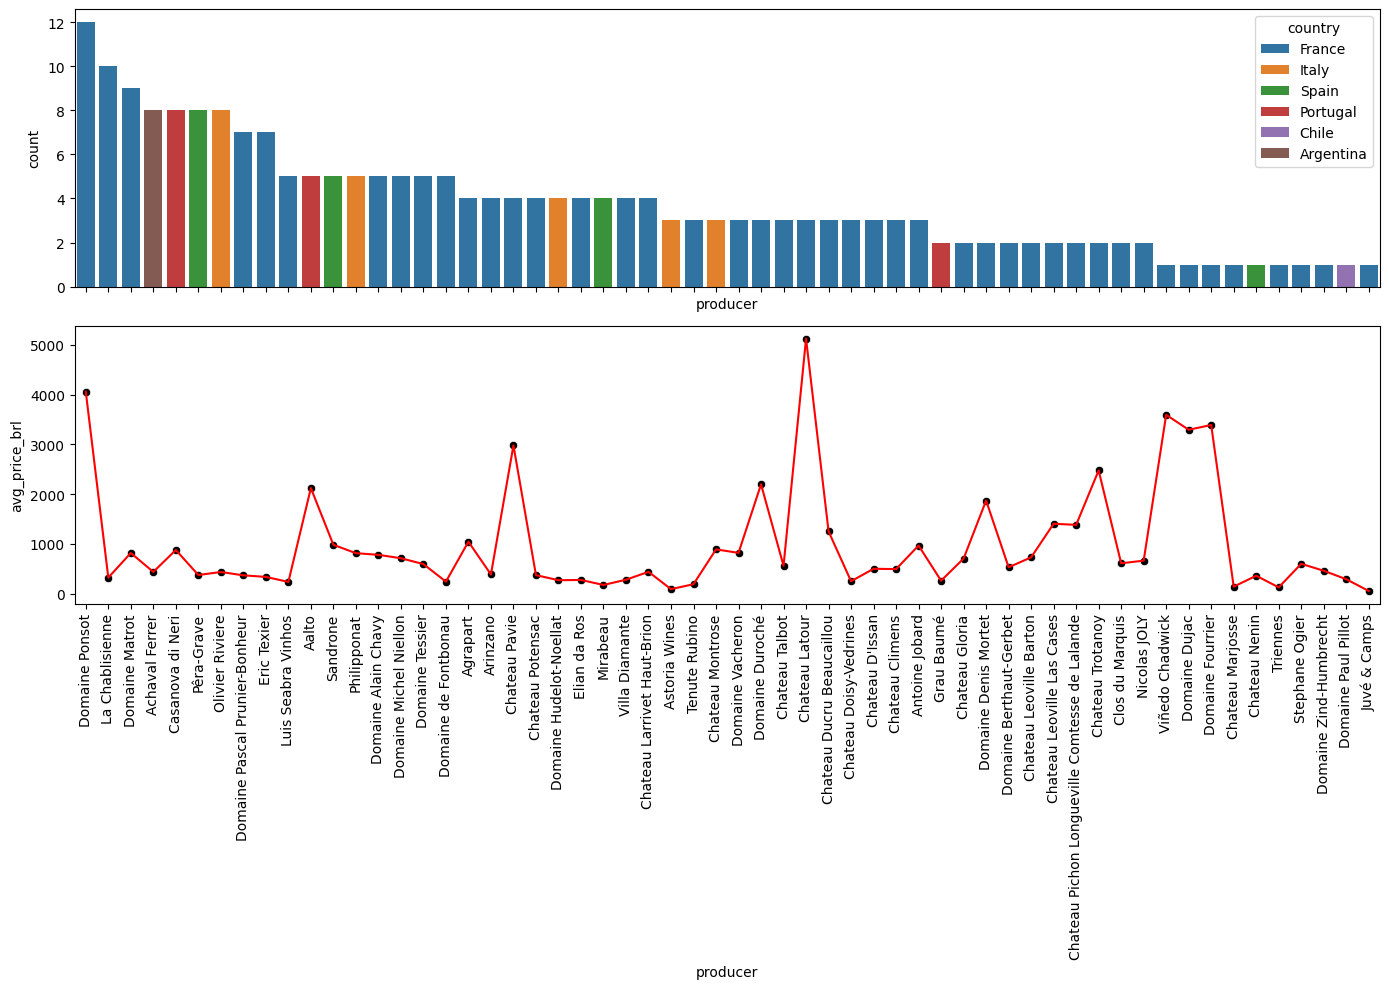

In [ ]:
fig, ax = plt.subplots(2,1,figsize=(14,10))

sns.countplot(data=df_products, x='producer', order=df_products.producer.value_counts().index, hue='country',palette=country_palette, ax=ax[0])
ax[0].set_xticklabels(ax[0].get_xticklabels(), visible=False)

sns.scatterplot(data=avg_price.sort_values(by='producers', ascending=False), x='producer', y='avg_price_brl',ax=ax[1], color='black')
sns.lineplot(data=avg_price.sort_values(by='producers', ascending=False), x='producer', y='avg_price_brl',ax=ax[1], color='red')
ax[1].set_xlim(ax[0].get_xlim())
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=90)

plt.tight_layout();

In [ ]:
df_products.groupby(['country','kind'])['price_brl'].agg(['mean','median','min','max'])

mean  median     min      max
country   kind                                                
Argentina red              435.825000   387.3   135.0    999.0
Chile     red             3594.000000  3594.0  3594.0   3594.0
France    red             1500.857831   619.2   125.4  10992.0
          rose             173.850000   147.6   115.2    285.0
          rose sparkling   694.200000   694.2   489.0    899.4
          sparkling        978.514286   814.8   339.6   1548.0
          white            639.496552   544.5    99.6   3294.0
Italy     red              819.440000   759.0   119.4   2796.0
          rose             199.800000   199.8   199.8    199.8
          rose sparkling    74.400000    74.4    74.4     74.4
          sparkling         97.200000    97.2    95.4     99.0
          white            279.000000   279.0   279.0    279.0
Portugal  red              350.072727   289.2   135.0    669.0
          white            208.300000   167.1    99.6    399.4
Spain     red             1048.714286   499.2   149.4   4992.0
          sparkling         52.800000    52.8    52.8     52.8
          white            312.400000   249.0   139.2    549.0

In [ ]:
country_list = df_products.country.value_counts().index
avg_country = df_products.groupby('country')['price_brl'].mean().reindex(country_list)

In [ ]:
region_list = df_products.region.value_counts().index
avg_region = df_products.groupby(['country','region'])['price_brl'].mean().reset_index()
avg_region['region'] = pd.Categorical(avg_region['region'], categories=region_list, ordered=True)
avgg_region = avg_region.sort_values('region')

In [ ]:
avg_kind = df_products.groupby('kind')['price_brl'].mean()

<ipython-input-13-297cef31734a>:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=90)


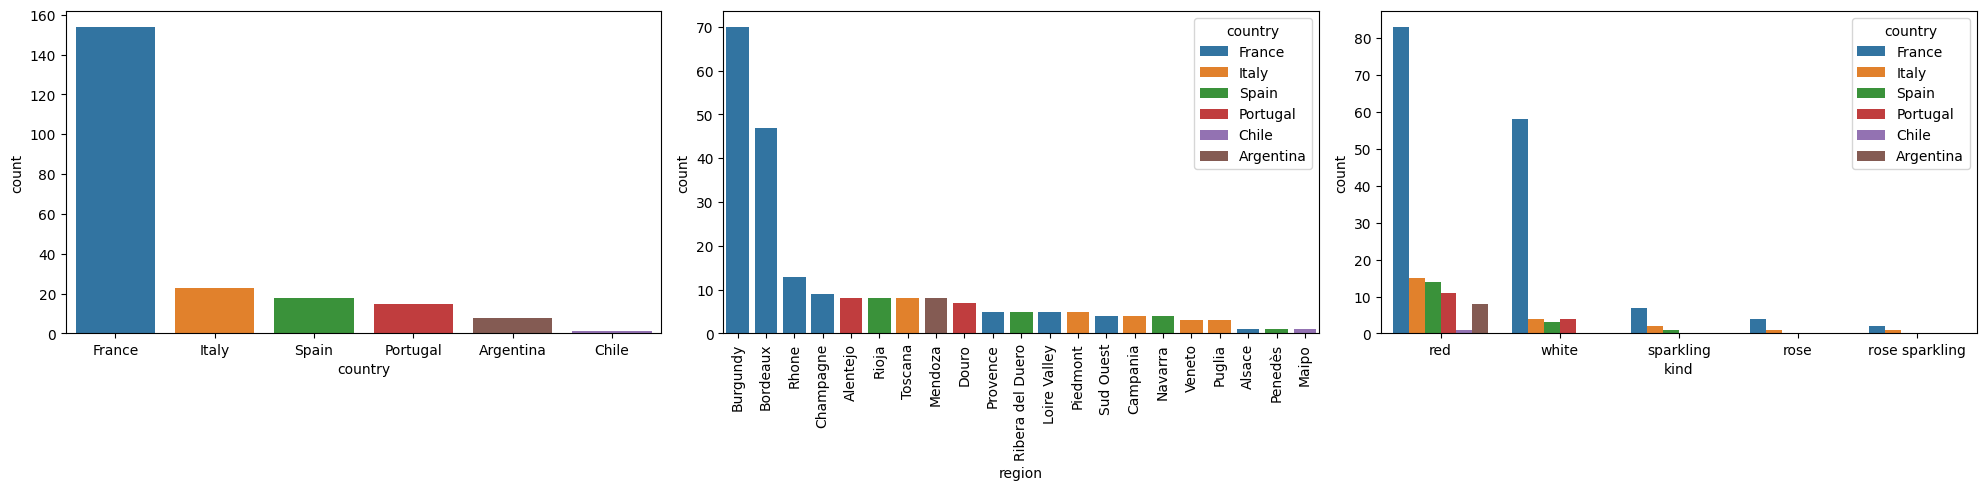

In [ ]:
fig, ax = plt.subplots(1,3, figsize=(20,5))

sns.countplot(x=df_products.country, order=df_products.country.value_counts().index, ax=ax[0], hue=df_products.country)

sns.countplot(x=df_products.region, order=df_products.region.value_counts().index, hue=df_products.country, ax=ax[1])
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=90)

sns.countplot(x=df_products.kind, order=df_products.kind.value_counts().index, hue=df_products.country, ax=ax[2])

plt.tight_layout();

<ipython-input-54-7313cfd320f5>:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=90);


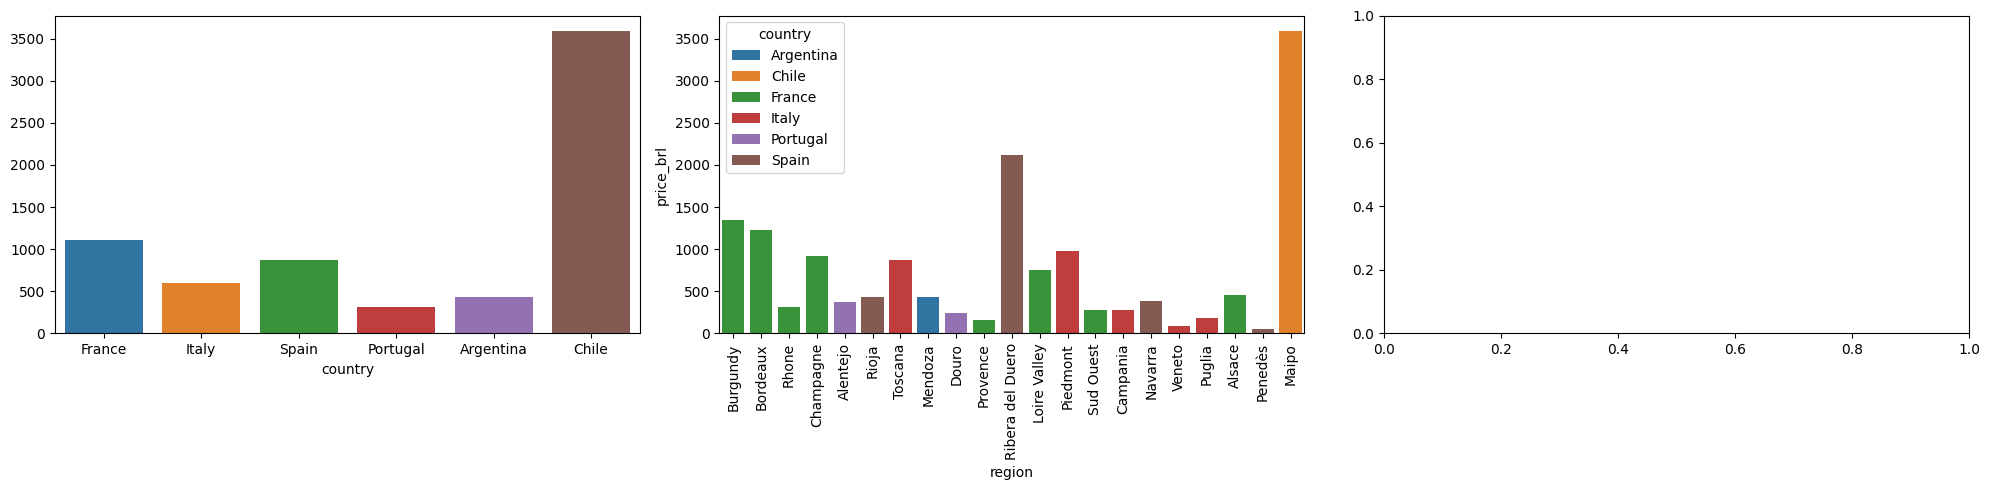

In [ ]:
fig, ax = plt.subplots(1,3, figsize=(20,5))

sns.barplot(x= avg_country.index, y=avg_country.values,hue=avg_country.index, ax=ax[0])

sns.barplot(data=avg_region, x='region',y='price_brl', hue='country',ax=ax[1])
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=90);

plt.tight_layout();

In [ ]:
df_products.groupby(['country','vintage'])['price_brl'].agg(['mean','median','min','max'])

mean  median     min      max
country   vintage                                      
Argentina 2014      709.200000   649.2   539.4    999.0
          2015      235.200000   235.2   235.2    235.2
          2017      139.800000   139.8   139.8    139.8
          2018      135.000000   135.0   135.0    135.0
Chile     2017     3594.000000  3594.0  3594.0   3594.0
France    0         575.700000   574.2   339.6    814.8
          2002     9594.000000  9594.0  9594.0   9594.0
          2003      499.400000   549.6   299.4    649.2
          2004      424.500000   424.5   299.4    549.6
          2007     5994.000000  5994.0  5994.0   5994.0
          2008      679.200000   679.2   459.0    899.4
          2009     1168.500000  1168.5   789.0   1548.0
          2010     3424.500000  3424.5   849.6   5999.4
          2011     1437.400000  1346.7   289.2   2892.0
          2012     1271.720000   799.2   290.2   2892.0
          2013      856.420000   999.0   285.0   1499.4
          2014     1235.350000   644.4   125.4   4392.0
          2015      818.160000   379.5   165.0   3792.0
          2016     1062.342857   249.6   139.8   3792.0
          2017     1479.000000   619.2   175.8  10992.0
          2018      773.874468   619.2   159.6   3390.0
          2019      196.860000   162.3    99.6    359.4
Italy     0          89.600000    95.4    74.4     99.0
          2013     2796.000000  2796.0  2796.0   2796.0
          2014     1185.000000  1185.0  1098.0   1272.0
          2015      812.485714   999.0   189.6   1290.0
          2016      165.600000   165.6   165.6    165.6
          2017      359.100000   279.0   119.4    759.0
          2018      230.400000   229.2   165.0    279.0
Portugal  2015      599.400000   599.4   599.4    599.4
          2016      435.360000   319.8   289.2    669.0
          2017      220.950000   224.4   145.8    289.2
          2018      263.133333   255.0   135.0    399.4
          2019      117.300000   117.3    99.6    135.0
Spain     0          52.800000    52.8    52.8     52.8
          2014      699.000000   699.0   699.0    699.0
          2016      709.350000   554.1   439.2   1290.0
          2017      246.000000   149.4   149.4    439.2
          2018     1260.533333   429.0   139.2   4992.0

## Analisando as Vendas

In [ ]:
df_sales = pd.read_csv('https://raw.githubusercontent.com/rafaelnduarte/sigmoidal_data/master/sales-clean.csv')
print(df_sales.shape)
df_sales.head()

(720071, 4)


,date,store,item,sales
0,2018-01-01,1,1,13
1,2018-01-02,1,1,11
2,2018-01-03,1,1,14
3,2018-01-04,1,1,13
4,2018-01-05,1,1,10
